## Case 1：空氣污染的空間分布特徵

#### 本案例將提供使用者於衛星影像上框選目標區域，觀察及計算空氣污染指標 

<div style="display: inline-block;">
    <img src="pic/CO_avg.png" alt="CO_avg" width="440"/>
</div>

本案例使用之空氣污染圖資係由國立成功大學測量及空間資訊學系吳治達副教授團隊，基於「地理空間人工智慧(Geo-AI)」技術所發展之「集成混合空間推估模型(Ensemble Mixed Spatial Prediction Model, EMSM)」進行空污分布模擬之成果，相關學術發表見以下連結： 

PM2.5模型成果：DOI: 10.1016/j.scitotenv.2022.161336，

NO2模型成果：DOI: doi.org/10.1016/j.jclepro.2021.128411，

O3模型成果：DOI: 10.1016/j.jhazmat.2023.130749，

Benzene模型成果：DOI: 10.1016/j.chemosphere.2022.134758

In [1]:
import matplotlib # 用來顯示影像及繪圖
matplotlib.rc('font', family='Microsoft JhengHei') # 設定中文字形
# 設定matplotlib的後端
matplotlib.use('TkAgg')

from PIL import Image, ImageDraw # 用來讀取影像及繪圖
from io import BytesIO  # 用來將response內容轉成PIL可讀的格式
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon

import requests # 用來發送HTTP Request
import numpy as np # 用來做數值運算
import urllib3
urllib3.disable_warnings()

In [8]:
#GDXP帳號及介接安全碼
%store -r username
%store -r token
#GDXP URL
%store -r gdxp1
%store -r gdxp3

In [9]:
#空污圖資(實際資料)
queryair='''
for $c in ( taiwan_air_quality_monitoring_data_co )
let $sub := [ansi("2021-01-01T00:00:00.000Z"),X(241996:255080), Y(2738036:2750180)]
 return encode(
             $c[ $sub ]                   
        , "tiff")'''

In [10]:
#空污圖資(展示用)
#將數值區間轉為0-255並使用colortable設定色彩樣式
queryairpng='''
for $c in ( taiwan_air_quality_monitoring_data_co )
let $sub := [ansi("2021-01-01T00:00:00.000Z"),X(241996:255080), Y(2738036:2750180)]
 return encode(
              ($c[ $sub ] - min($c[ $sub ])) / (max($c[ $sub ]) - min($c[ $sub ])) * 255                    
        , "png",
        "{\\\"colorMap\\\":{\\\"type\\\":\\\"intervals\\\",
        \\\"colorTable\\\":
        {\\\"0\\\":[255, 235, 230,145],\\\"50\\\":[255, 173, 153,145],
        \\\"100\\\":[255, 71, 26,145],\\\"150\\\":[230, 46, 0,145],
        \\\"200\\\":[179, 36, 0,145],\\\"250\\\":[128, 26, 0,145]}}}"
        )'''

In [11]:
#福衛五號影像(展示用)
queryFS5='''
for $c in ( FS5_MS_NSPO )
let $sub := [X(241996:255080), Y(2738036:2750180),ansi("2018-12-17T02:58:13.000Z")]
 return encode({
             b1: $c.band1_red[$sub]/12;
             b2: $c.band2_green[$sub]/12;
             b3: $c.band3_blue[$sub]/12
             }
        , "png")'''

In [12]:
# 送出 request
response = requests.post(gdxp1, data = {'query': queryair}, verify=False, auth = (username, token))
responsepng = requests.post(gdxp1, data = {'query': queryairpng}, verify=False, auth = (username, token))
responsefs5 = requests.post(gdxp3, data = {'query': queryFS5}, verify=False, auth = (username, token))

# 將 Response 轉成 PIL Image可讀的型態
airimg = Image.open(BytesIO(response.content))
imgpng = Image.open(BytesIO(responsepng.content))
imgfs5 = Image.open(BytesIO(responsefs5.content))  

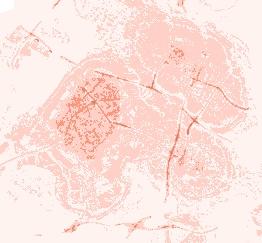

In [13]:
Image.open(BytesIO(responsepng.content))

In [14]:
# 定義函式計算空污濃度平均值
def calculate_channel_average(image, polygons):
    mask = Image.new('1', image.size, 0)
    
    average_colors = []

    for polygon_points in polygons:
        ImageDraw.Draw(mask).polygon(polygon_points, outline=1, fill=1)
        mask_arr = np.array(mask)
        channel_data = np.array(image)[:, :]
        channel_pixels = channel_data[mask_arr == 1]
        
        if len(channel_pixels) == 0:
            average_colors.append(None)
        else:
            average_color = np.mean(channel_pixels)
            average_colors.append(average_color)

    return average_colors

In [15]:
# 福衛五號影像(展示用)
imgfs5 = imgfs5.convert("RGBA")

# 讀取空氣汙染圖(展示用)，resize成與福衛五號影像相同的大小
imgpng_resized = imgpng.resize(imgfs5.size, Image.LANCZOS)


# 讀取實際空氣汙染指標
airimg = airimg.resize(imgfs5.size, Image.LANCZOS)
fig, ax = plt.subplots(figsize=(14, 8))  # 設定繪圖介面的大小

ax.imshow(imgfs5)
ax.axis('off')
plt.title('框選範圍以計算一氧化碳濃度(按Enter結束繪製)')
polygons_list = []  # 儲存多個polygon的點
while True:
   
    x = plt.ginput(0, timeout=-1)  # 點擊多個點，不限制數量

    if not x:  # 如果按下Enter，退出循環
        break

    polygons_list.append(x)  # 儲存多邊形的點
    poly_patch = Polygon(x, closed=True, fill=None, edgecolor='m')  # 建立多邊形物件
    ax.add_patch(poly_patch)  # 將多邊形加到圖中

# 將多個polygon裁切並套疊在圖上
for polygon in polygons_list:
    mask = Image.new('L', imgfs5.size, 0)
    draw = ImageDraw.Draw(mask)
    draw.polygon(polygon, fill=255)
    imgpng_resized_alpha = imgpng_resized.copy()
    imgfs5.paste(imgpng_resized_alpha, (0, 0), mask) 
    
plt.imshow(imgfs5)


average_colors = calculate_channel_average(airimg, polygons_list)
# 將平均值標註在影像上
for i, avg_color in enumerate(average_colors):
    if avg_color is not None:
        x, y = polygons_list[i][0]  #取第一點為標註位置
        
        # 標註文字內容及樣式
        annotation_text = f'Avg: {avg_color:.2f} ppm'        
        bbox_style = dict(boxstyle='square,pad=0.2', facecolor='white', edgecolor='none', alpha=0.7)       
        plt.annotate(annotation_text, (x, y), color='black', fontsize=9, fontweight='bold', bbox=bbox_style)

plt.show(block = False)

print("一氧化碳平均值:", average_colors, "ppm")


一氧化碳平均值: [0.4649696, 0.53592664] ppm
